In [ ]:
!pip install anndata

In [17]:
import anndata as ad
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [4]:
%load_ext autoreload
%autoreload 2
from google.colab import drive
import os
gdrive_path='/content/gdrive/MyDrive/Masterpraktikum'
drive.mount('/content/gdrive', force_remount=True)
os.chdir(gdrive_path)

Mounted at /content/gdrive


# Imputation of missing values in the JUMP dataset

## Data

The data contains the sentinel plates (TARGET2) and the positive and negative controls from the production plates (COMPOUND). There are 8 different positive controls and DMSO is used as negative control.

All 4762 features were loaded.

The data stems from the principal data set (cpg0016) which uses human U2OS osteosarcoma cells.

**Let's have a look at the missing values**
1. Let us first only consider the TARGET2 plates.

In [5]:
adata_target2 = ad.read_h5ad("/content/gdrive/MyDrive/Masterpraktikum/Blockteil/target2_md.h5ad")
adata_target2

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 64464 × 4762
    obs: 'Metadata_Source', 'Metadata_Plate', 'Metadata_Well', 'Metadata_JCP2022', 'Metadata_InChIKey', 'Metadata_InChI', 'Metadata_Microscope_Name', 'Metadata_Widefield_vs_Confocal', 'Metadata_Excitation_Type', 'Metadata_Sites_Per_Well', 'broad_sample', 'InChIKey', 'pert_iname', 'pubchem_cid', 'target', 'pert_type', 'control_type', 'smiles'

How many inf/nan values do we have in total?

In [6]:
print(f"Number of inf: {np.sum(np.isinf(adata_target2.X))}")
print(f"Number of nan: {np.sum(np.isnan(adata_target2.X))}")

Number of inf: 33
Number of nan: 5261


What does the distribution of percentages of inf/nan values of the features look like?

In [7]:
adata_target2.X[np.isinf(adata_target2.X)] = np.nan

In [12]:
percentages = np.isnan(adata_target2.X).sum(axis=0) * 100 / adata_target2.X.shape[0]
percentages

array([0., 0., 0., ..., 0., 0., 0.])

In [16]:
max(percentages)

6.74795234549516

In [25]:
len(percentages[percentages > 0])

11

In [28]:
percentages[percentages > 0]

array([6.74795235, 0.01085877, 0.01085877, 0.01551253, 0.01551253,
       0.01085877, 0.01085877, 1.34338546, 0.01396128, 0.01861504,
       0.01396128])

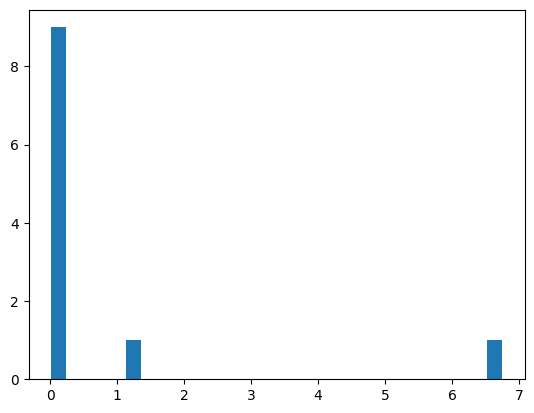

In [24]:
plt.hist(percentages[percentages > 0], bins = 30)
plt.show()

2. Let's have a look at the Target2 plates **and** the controls of the COMPOUND plates

In [ ]:
data_file = "../../data/jump/jump_raw.h5ad"
if not os.path.exists(data_file):
    raise FileNotFoundError("Please create the data file by downloading the JUMP data and creating an AnnData object.")

In [ ]:
adata = sc.read_h5ad(data_file)
print(adata)
adata.obs.head()

/home/stockhaus/miniconda3/envs/mp/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 215995 × 4762
    obs: 'Metadata_JCP2022', 'Metadata_InChIKey', 'Metadata_InChI', 'Metadata_Source', 'Metadata_Plate', 'Metadata_Well', 'Metadata_PlateType'


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_PlateType
0,JCP2022_000794,AECDBHGVIIRMOI-UHFFFAOYSA-N,InChI=1S/C27H29N5O/c28-26-25-24(21-8-4-9-23(14...,source_10,Dest210726-160150,G21,TARGET2
1,JCP2022_000794,AECDBHGVIIRMOI-UHFFFAOYSA-N,InChI=1S/C27H29N5O/c28-26-25-24(21-8-4-9-23(14...,source_10,Dest210727-153003,G21,TARGET2
2,JCP2022_000794,AECDBHGVIIRMOI-UHFFFAOYSA-N,InChI=1S/C27H29N5O/c28-26-25-24(21-8-4-9-23(14...,source_10,Dest210803-153958,G21,TARGET2
3,JCP2022_000794,AECDBHGVIIRMOI-UHFFFAOYSA-N,InChI=1S/C27H29N5O/c28-26-25-24(21-8-4-9-23(14...,source_10,Dest210809-134534,G21,TARGET2
4,JCP2022_000794,AECDBHGVIIRMOI-UHFFFAOYSA-N,InChI=1S/C27H29N5O/c28-26-25-24(21-8-4-9-23(14...,source_10,Dest210810-173723,G21,TARGET2


In [ ]:
print(f"Number of inf: {np.sum(np.isinf(adata.X))}")
print(f"Number of nan: {np.sum(np.isnan(adata.X))}")

Number of inf: 160
Number of nan: 17160


In [ ]:
adata.X[np.isinf(adata.X)] = np.nan

In [ ]:
nan_count = np.count_nonzero(np.isnan(adata.X), axis=0)

In [ ]:
np.sort(nan_count)

array([    0,     0,     0,     0,     0,     0,     0, ...,    25,    25,
          71,   114,   114,  2765, 14120])

In [ ]:
adata.var.index.values[np.where(nan_count == np.max(nan_count))[0][0]]

'Cells_AreaShape_FormFactor'

One feature (Cells_AreaShape_FormFactor) has quite high number (14 120) of nan values. Among the total number of observations (215 995), this is about 6.5%. The feature with the next highest number of nan values has a fraction of about 1.3%, all other features have below 0.06% nan values.